In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Combining CSV's into single dataframe (Label1)

In [ ]:
import pandas as pd
import re
from collections import Counter

# ------------------------------
# 1. Combine All Train Files
# ------------------------------

def majority_vote(row, annotator_cols):
    votes = [row[col] for col in annotator_cols if pd.notnull(row[col])]
    if not votes:
        return 0  # Default if no votes available
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common()
    # In case of a tie, default to 0
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0
    return most_common[0][0]

# List of training files
train_files = [
    "/content/drive/MyDrive/NLP_Project/baseline/data/training/train_en_l1.csv",
    "/content/drive/MyDrive/NLP_Project/baseline/data/training/train_hi_l1.csv",
    "/content/drive/MyDrive/NLP_Project/baseline/data/training/train_ta_l1.csv"
]

dfs = []

for f in train_files:
    temp_df = pd.read_csv(f)

    # Identify language and corresponding annotator columns
    if "_en_" in f:
        annotator_cols = ["en_a1", "en_a2", "en_a3", "en_a4", "en_a5", "en_a6"]
        temp_df["language"] = "en"
    elif "_hi_" in f:
        annotator_cols = ["hi_a1", "hi_a2", "hi_a3", "hi_a4", "hi_a5"]
        temp_df["language"] = "hi"
    else:  # Assuming Tamil files have "_ta_"
        annotator_cols = ["ta_a1", "ta_a2", "ta_a3", "ta_a4", "ta_a5"]
        temp_df["language"] = "ta"

    # Apply majority vote to compute final_label for each row
    temp_df["final_label"] = temp_df.apply(lambda row: majority_vote(row, annotator_cols), axis=1)

    # Keep only needed columns
    temp_df = temp_df[["text", "final_label", "language"]]
    dfs.append(temp_df)

# Combine all training DataFrames
train_df = pd.concat(dfs, ignore_index=True)
print("Combined training data shape:", train_df.shape)
print(train_df.head())

# ------------------------------
# 2. Preprocessing Functions
# ------------------------------

# --- English Preprocessing ---
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'#\w+', '', text)                  # Remove hashtags
    text = re.sub(r'<handle replaced>', '', text)       # Remove handle placeholders
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Remove emojis and other non-alphanumeric characters (keep basic punctuation)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]', '', text)                 # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    return text

# --- Hindi Preprocessing ---
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'<handle replaced>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Preserve Hindi characters (Unicode range \u0900-\u097F) and numerals/spaces
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- Tamil Preprocessing ---
def preprocess_tamil_text(text):
    if not isinstance(text, str):
        return ""
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove emojis using a regex
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Preserve Tamil characters (Unicode range \u0B80-\u0BFF), numerals, and spaces; remove others
    text = re.sub(r'[^\u0B80-\u0BFF0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --- Unified Preprocessing Function ---
def preprocess_text(row):
    language = row['language']
    text = row['text']
    if language == 'en':
        return preprocess_english_text(text)
    elif language == 'hi':
        return preprocess_hindi_text(text)
    elif language == 'ta':
        return preprocess_tamil_text(text)
    else:
        return text  # Fallback if language is unknown

# Apply preprocessing to the combined DataFrame
train_df['clean_text'] = train_df.apply(preprocess_text, axis=1)
# print("\nSample preprocessed texts:")
# print(train_df[['language', 'text', 'clean_text']].head())

# ------------------------------
# 3. Next Step: Create HuggingFace Dataset
# ------------------------------

Combined training data shape: (19507, 3)
                                                text final_label language
0      This is our history . For Shia and Sunni ,...         0.0       en
1     If this is "grilling" then wht wud u call t...         1.0       en
2    look at <handle replaced>madam. Locals attac...         0.0       en
3    our beloved yogi ji has given money home and...         1.0       en
4  "I gonna kill that bitch"  Bitvj imma kill you...         1.0       en


In [ ]:
# Rename 'clean_text' to 'text' and then drop 'clean_text'
train_df = train_df.drop(columns=["text"])
train_df = train_df.rename(columns={"clean_text": "text"})

print(train_df.head())

  final_label language                                               text
0         0.0       en  this is our history for shia and sunni dont li...
1         1.0       en  if this is grilling then wht wud u call th stu...
2         0.0       en  look at madam locals attacked no religion angl...
3         1.0       en  our beloved yogi ji has given money home and f...
4         1.0       en  i gonna kill that bitch bitvj imma kill you we...


In [ ]:
train_df = train_df[['text', 'final_label', 'language']]
print(train_df.head())
print(train_df.tail(10))  # Prints the last 10 rows

                                                text final_label language
0  this is our history for shia and sunni dont li...         0.0       en
1  if this is grilling then wht wud u call th stu...         1.0       en
2  look at madam locals attacked no religion angl...         0.0       en
3  our beloved yogi ji has given money home and f...         1.0       en
4  i gonna kill that bitch bitvj imma kill you we...         1.0       en
                                                    text final_label language
19497  நேத்து ஒரு ல இதைத்தான் உரிட்டிட்டு இருந்தானுங்...         0.0       ta
19498  ரயில்ல கல்லு விட்டதுக்கு இப்ப வாயிலயே குடுத்து...         0.0       ta
19499  தேவ்டியா பையா என் சுன்னிக்கு மொதல் பதில் சொல்ல...         1.0       ta
19500                                         மக்கு கூதி         1.0       ta
19501  ஓத்த ஓழுல புன்டயில ஓத்தலம் போட போன வேச புன்டக்...         1.0       ta
19502                              ஒம்மாள படிக்கல் புண்ட         1.0       ta
19503  என்

In [ ]:
# Step 1: Install required libraries (if not already installed)
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

## Tokenization Indic-BERT-v2

In [ ]:
# Step 2: Import necessary modules
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Load your cleaned DataFrame
print(train_df.head())

# Ensure final_label is numeric
train_df['final_label'] = pd.to_numeric(train_df['final_label'], errors='coerce')

# Convert DataFrame to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(train_df)

# Perform 80/20 Train/Validation Split
dataset_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    "train": dataset_split["train"],
    "validation": dataset_split["test"]
})

# Inspect the split
print("Train dataset size:", dataset_dict["train"].num_rows)
print("Validation dataset size:", dataset_dict["validation"].num_rows)

# Change the model name to IndicBERT v2
model_name = "ai4bharat/indic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

# Inspect a tokenized sample
print(tokenized_dataset["train"][1000])


                                                text  final_label language
0  this is our history for shia and sunni dont li...          0.0       en
1  if this is grilling then wht wud u call th stu...          1.0       en
2  look at madam locals attacked no religion angl...          0.0       en
3  our beloved yogi ji has given money home and f...          1.0       en
4  i gonna kill that bitch bitvj imma kill you we...          1.0       en
Train dataset size: 15605
Validation dataset size: 3902


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Map:   0%|          | 0/15605 [00:00<?, ? examples/s]

Map:   0%|          | 0/3902 [00:00<?, ? examples/s]

{'text': 'சொன்னா எங்கடா விட்றான் மொரட்டு குடி குடிச்சா தான் உங்கொம்மாள பொட்டு ஓக்க முடியும்னு சண்ட போட்டு குடிக்கிறான்', 'final_label': 1.0, 'language': 'ta', 'input_ids': [2, 62082, 1173, 5395, 73270, 110202, 7219, 195772, 19315, 5448, 5448, 21839, 21839, 5013, 5013, 25338, 5559, 73270, 32142, 110005, 5010, 5448, 4608, 1385, 1385, 30300, 1299, 31499, 3018, 7859, 5448, 5010, 5448, 108531, 1385, 195772, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
tokenized_dataset = tokenized_dataset.rename_column("final_label", "labels")

## Finetuning Indic-BERT

In [ ]:
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support
from datasets import DatasetDict, Value

# ---- STEP 1: Ensure labels are integers ----
def cast_to_int(example):
    example['labels'] = int(example['labels']) if example['labels'] is not None else 0
    return example

tokenized_dataset = tokenized_dataset.map(cast_to_int)
tokenized_dataset = tokenized_dataset.cast_column("labels", Value("int64"))

# ---- STEP 2: Compute Metrics ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        "precision": precision,
        "recall": recall,
        "macro_f1": f1
    }

# ---- STEP 3: Load IndicBERT Model and Tokenizer ----
model_name = "ai4bharat/indic-bert"  # v2 might be gated
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ---- STEP 4: Training Arguments ----
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP_Project/indic_bert_gendered_abuse",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_strategy="epoch",
)

# ---- STEP 5: Trainer Setup ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

# ---- STEP 6: Train ----
trainer.train()

# ---- STEP 7: Evaluate ----
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


Map:   0%|          | 0/15605 [00:00<?, ? examples/s]

Map:   0%|          | 0/3902 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15605 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3902 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,Macro F1
1,0.563500,0.502715,0.742580,0.620553,0.630286
2,0.484500,0.473168,0.725288,0.706808,0.714434
3,0.432000,0.502864,0.724640,0.705656,0.713442
4,0.364300,0.544528,0.711448,0.708385,0.709863
5,0.286900,0.790973,0.705988,0.695306,0.700008
6,0.221000,0.962078,0.696774,0.696044,0.696406
7,0.163800,1.227735,0.690915,0.679546,0.684422
8,0.121900,1.471513,0.686018,0.695928,0.690217
9,0.093900,1.603672,0.677319,0.674944,0.676089
10,0.072000,1.638544,0.681039,0.679300,0.680148


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Evaluation Results: {'eval_loss': 0.4731675684452057, 'eval_precision': 0.7252879283551795, 'eval_recall': 0.7068081653963687, 'eval_macro_f1': 0.7144344381348217, 'eval_runtime': 27.8335, 'eval_samples_per_second': 140.191, 'eval_steps_per_second': 8.766, 'epoch': 10.0}


## Evaluation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch

# 🔄 Load trained model from checkpoint
model_checkpoint_path = "/content/drive/MyDrive/NLP_Project/indic_bert_gendered_abuse/checkpoint-best"  # Change if needed
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_path)

# If you have a GPU, move the model to the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)

# Reinitialize trainer with the loaded model
trainer.model = model

# Step 1: Run predictions
predictions_output = trainer.predict(tokenized_dataset["validation"])

# Step 2: Extract logits, preds, and labels
logits = predictions_output.predictions
labels = predictions_output.label_ids
preds = np.argmax(logits, axis=1)

# Step 3: Compute evaluation metrics
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')
print(f" Evaluaton results for Indic-BERT")
print(f" Precision (macro): {precision:.4f}")
print(f" Recall    (macro): {recall:.4f}")
print(f" Macro- F1 Score  (macro): {f1:.4f}")

# Step 4: Collect input texts
input_texts = tokenized_dataset["validation"]["text"]

# Step 5: Create DataFrame
df = pd.DataFrame({
    "text": input_texts,
    "true_label": labels,
    "predicted_label": preds
})

# Step 6: Save to CSV
csv_path = "/content/drive/MyDrive/NLP_Project/predictions_IndicBERT.csv"
df.to_csv(csv_path, index=False)
print(f"✅ Predictions saved to {csv_path}")

 Evaluaton results for Indic-BERT
 Precision (macro): 0.7246
 Recall    (macro): 0.7057
 Macro- F1 Score  (macro): 0.7134
✅ Predictions saved to /content/drive/MyDrive/NLP_Project/predictions_IndicBERT.csv


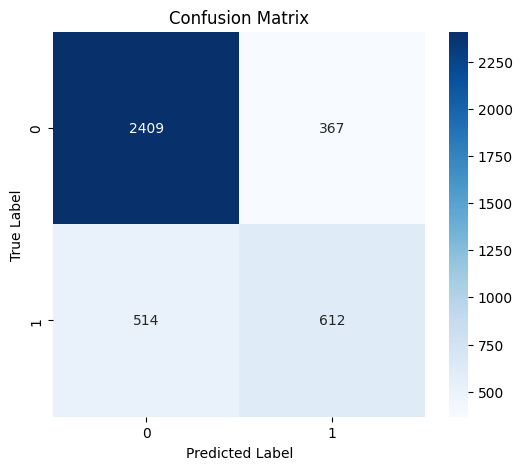

In [ ]:
# ✅ Step 7: Plot confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
